<a href="https://colab.research.google.com/github/luqmanbuang/Capstone/blob/master/Main_Phase_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import warnings 
warnings.filterwarnings('ignore')

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

#Importing both test and train datasets
df_test_FD001 = pd.read_csv('/content/gdrive/My Drive/Capstone/test_FD001.txt', sep=' ', header=None)
df_train_FD001 = pd.read_csv('/content/gdrive/My Drive/Capstone/train_FD001.txt', sep=' ', header=None)


# dropping NAN values
df_test_FD001 = df_test_FD001.dropna(axis=1, how='all')
df_train_FD001 = df_train_FD001.dropna(axis=1, how='all')

# Naming the columns
df_test_FD001.columns = ["unit", "cycles", "Op1",
                      "Op2", "Op3", "S1", "S2",
                      "S3", "S4", "S5", "S6", "S7", "S8", "S9", "S10", "S11",
                      "S12", "S13", "S14", "S15", "S16", "S17", "S18", "S19", "S20", "S21"]

df_train_FD001.columns = ["unit", "cycles", "Op1",
                      "Op2", "Op3", "S1", "S2",
                      "S3", "S4", "S5", "S6", "S7", "S8", "S9", "S10", "S11",
                      "S12", "S13", "S14", "S15", "S16", "S17", "S18", "S19", "S20", "S21"]

# data preprocessing; removing unnecessary data
df_test_FD001.drop(['Op3','S1', 'S5', 'S6', 'S16', 'S10', 'S18', 'S19'], axis=1, inplace=True)
df_train_FD001.drop(['Op3','S1', 'S5', 'S6', 'S16', 'S10', 'S18', 'S19'], axis=1, inplace=True)

# test dataset begins with unit 101 to differentiate from the train dataset
df_test_FD001['unit'] += 100


In [4]:
# Combine the two datasets into a single dataframe
df_combined = pd.concat([df_train_FD001, df_test_FD001]) 

from sklearn.preprocessing import MinMaxScaler

# Perform scalling on the the combined dataset so that their scale is the same
scaler = MinMaxScaler()
df_combined.iloc[:,2:18] = scaler.fit_transform(df_combined.iloc[:,2:18])

In [5]:
# Split them again after performing scalling
df_train_FD001 = df_combined[(df_combined.unit <= 100)]
df_test_FD001 = df_combined[(df_combined.unit >= 101)]

# After separation, the first unit of the test dataset is reset to 0 again
df_test_FD001['unit'] -= 100

In [6]:
# Finding the maximum cycle of an engine unit which is used to find its Remaining Useful Life (RUL)
df_train_FD001 = pd.merge(df_train_FD001, df_train_FD001.groupby('unit', as_index=False)['cycles'].max(), how='left', on='unit')
df_train_FD001.rename(columns={"cycles_x": "cycles", "cycles_y": "Total Cycles"}, inplace=True)

df_train_FD001['RUL'] = df_train_FD001['Total Cycles'] - df_train_FD001['cycles']

# Defining the Health Index, where value of 1 denotes healthy engine and 0 denotes failure
def fractionTTF(dat,q):
    return(dat.RUL[q]-dat.RUL.min()) / (dat.RUL.max()-dat.RUL.min())

fTTFz = []
fTTF = []

for i in range(df_train_FD001['unit'].min(),df_train_FD001['unit'].max()+1):
    dat=df_train_FD001[df_train_FD001.unit==i]
    dat = dat.reset_index(drop=True)
    for q in range(len(dat)):
        fTTFz = fractionTTF(dat, q)
        fTTF.append(fTTFz)

df_train_FD001['Health Index'] = fTTF


In [7]:
# Defining train values that will be used to train the machine learning model
X_train = df_train_FD001[['cycles', 'Op1', 'Op2', 'S2', 'S3', 'S4', 'S7', 'S8', 'S9', 'S11', 'S12',
          'S13', 'S14', 'S15', 'S17', 'S20', 'S21']].values
y_train = df_train_FD001[['Health Index']].values.ravel()

# Defining test values that will be used to perform prediction based on the trained model
X_test = df_test_FD001[['cycles', 'Op1', 'Op2', 'S2', 'S3', 'S4', 'S7', 'S8', 'S9', 'S11', 'S12',
          'S13', 'S14', 'S15', 'S17', 'S20', 'S21']].values

In [8]:
# Importing keras deep learning API into colab notebook
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.wrappers.scikit_learn import KerasRegressor

# Defining Neural Network model
model = Sequential()
model.add(Dense(50, input_dim=17, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
model.compile(loss='mean_squared_error', optimizer='adam')

# Training the Neural Network model
model.fit(X_train, y_train, epochs = 50)

Epoch 1/50
645/645 [==============================] - 0s 580us/step - loss: 0.0343
Epoch 2/50
645/645 [==============================] - 0s 568us/step - loss: 0.0061
Epoch 3/50
645/645 [==============================] - 0s 570us/step - loss: 0.0059
Epoch 4/50
645/645 [==============================] - 0s 562us/step - loss: 0.0056
Epoch 5/50
645/645 [==============================] - 0s 569us/step - loss: 0.0057
Epoch 6/50
645/645 [==============================] - 0s 579us/step - loss: 0.0053
Epoch 7/50
645/645 [==============================] - 0s 575us/step - loss: 0.0053
Epoch 8/50
645/645 [==============================] - 0s 572us/step - loss: 0.0051
Epoch 9/50
645/645 [==============================] - 0s 568us/step - loss: 0.0050
Epoch 10/50
645/645 [==============================] - 0s 571us/step - loss: 0.0050
Epoch 11/50
645/645 [==============================] - 0s 580us/step - loss: 0.0050
Epoch 12/50
645/645 [==============================] - 0s 556us/step - loss: 0.0049
E

In [9]:
# Perform prediction of Health Index values based on the trained model
score = model.predict(X_test) 
df_test_FD001['Predicted H.I.'] = score

# df_test_FD001

In [10]:
# Calculating the predicted maximum cycle of the engine units
def totcycles(data):
    return(data['cycles'] / (1-data['Predicted H.I.']))
    
df_test_FD001['MaxPredCycles'] = totcycles(df_test_FD001)

# df_test_FD001

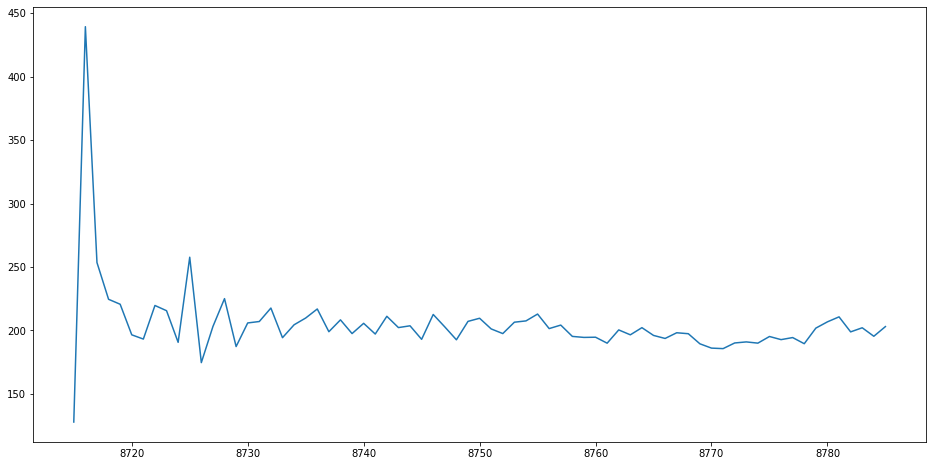

In [11]:
# Visualizing the predicted maximum cycles throughout each row of specified engine.
# It is observed that the extreme values are found in the beginning of the engine unit cycle.
# Ideal situation is that the predicted maximum cycles are uniform throughout the cycles.
 
plt.figure(figsize = (16, 8)) 
plt.plot(df_test_FD001.MaxPredCycles[(df_test_FD001['cycles'] >0) & (df_test_FD001['unit']==67)])

In [12]:
# Quick line that returns the average maximum cycle value of a particular engine unit 
# The values of the first 10 cycles are ignored to recieve more accurate results
df_test_FD001.MaxPredCycles[(df_test_FD001['cycles'] >10) & (df_test_FD001['unit']==80)].mean()

197.40687561035156

In [13]:
# Returns a uniform calculated average value throughout the engine cycle 
for i in range(df_test_FD001['unit'].min(),df_test_FD001['unit'].max()+1):
   df_test_FD001.MaxPredCycles[(df_test_FD001['unit'] == i)] = df_test_FD001.MaxPredCycles[(df_test_FD001['cycles'] >10) & (df_test_FD001['unit']==i)].mean()

In [14]:
# Calculating the predicted Cycles to Failure of the test dataset
df_test_FD001['Pred_RUL'] = df_test_FD001.MaxPredCycles * (df_test_FD001['Predicted H.I.'])

# df_test_FD001

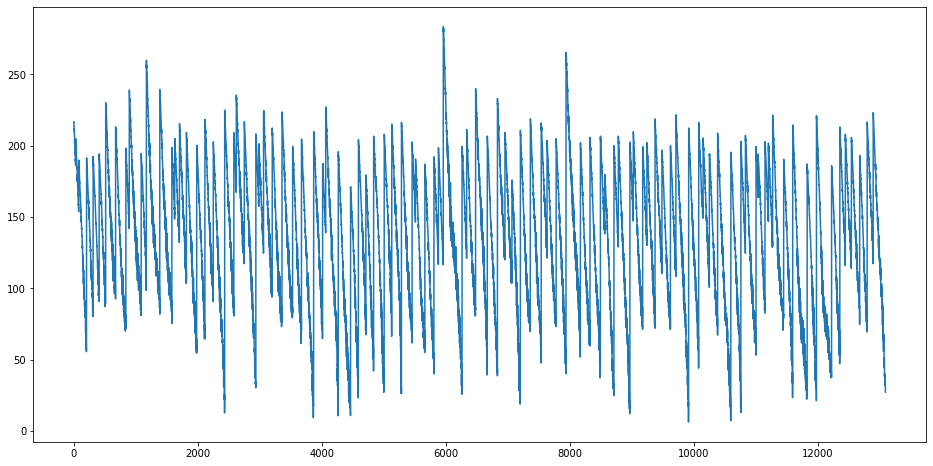

In [15]:
# Visualizing the predicted cycles of the engine units in the test dataset.
# x-axis represents the cycles 
plt.figure(figsize = (16, 8)) 
plt.plot(df_test_FD001.Pred_RUL)

In [16]:
# Returning the Remaining useful life of an engine unit of the test dataset.
# It is found by returning the minumum cycle to failure value of each engine unit
df_test_FD001.Pred_RUL[(df_test_FD001['unit']==94)].min()

47.01124954223633

In [17]:
# Appending the RUL values of each engine unit into an array
maxpred = []
for i in range(1,101):
  maxpred.append(df_test_FD001.Pred_RUL[(df_test_FD001['unit']==i)].min()) 

len(maxpred)

100

In [18]:
# Importing the actual RUL values from google drive
Results = pd.read_csv('/content/gdrive/My Drive/Capstone/RUL_FD001.txt', sep=' ', header=None)
Results = Results.dropna(axis=1, how='all')
Results.columns = ["Actual RUL"]

In [19]:
# Combining the Actual RUL values, predicted RUL values and computed difference between the two
Results = Results.assign(unit=[1 + i for i in range(len(Results))])[['unit'] + Results.columns.tolist()]
Results['Predicted RUL'] = maxpred
Results['Difference'] = Results['Actual RUL'] - Results['Predicted RUL']
Results.reset_index()
Results.set_index('unit')

,Actual RUL,Predicted RUL,Difference
unit,,,
1,112,186.249466,-74.249466
2,98,153.696915,-55.696915
3,69,55.485489,13.514511
4,82,80.160446,1.839554
5,91,90.752365,0.247635
...,...,...,...
96,137,114.070961,22.929039
97,82,74.561264,7.438736
98,59,69.306290,-10.306290


In [20]:
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

# Calculating the Root Mean Square Error of the actual and predicted values
RMSE = sqrt(mean_squared_error(Results['Actual RUL'], Results['Predicted RUL']))
print("RMSE: ", RMSE)

RMSE:  26.58951363997244


In [21]:
df_test_FD001.drop(['Op1','Op2', 'Op2', 'S2', 'S3', 'S4', 'S7', 'S8', 'S9',
                    'S11', 'S12', 'S13', 'S14', 'S15', 'S17', 'S20', 'S21'], axis=1, inplace=True)
df_test_FD001

,unit,cycles,Predicted H.I.,MaxPredCycles,Pred_RUL
0,1,1,0.990525,218.652527,216.580841
1,1,2,0.991098,218.652527,216.706177
2,1,3,0.991621,218.652527,216.820480
3,1,4,0.977438,218.652527,213.719223
4,1,5,0.977929,218.652527,213.826645
...,...,...,...,...,...
13091,100,194,0.141260,224.181946,31.668009
13092,100,195,0.146674,224.181946,32.881771
13093,100,196,0.147569,224.181946,33.082207
13094,100,197,0.137699,224.181946,30.869711


In [22]:
df_train_FD001.drop(['Op1','Op2', 'Op2', 'S2', 'S3', 'S4', 'S7', 'S8', 'S9',
                     'S11', 'S12', 'S13', 'S14', 'S15', 'S17', 'S20', 'S21'], axis=1, inplace=True)
df_train_FD001

,unit,cycles,Total Cycles,RUL,Health Index
0,1,1,192,191,1.000000
1,1,2,192,190,0.994764
2,1,3,192,189,0.989529
3,1,4,192,188,0.984293
4,1,5,192,187,0.979058
...,...,...,...,...,...
20626,100,196,200,4,0.020101
20627,100,197,200,3,0.015075
20628,100,198,200,2,0.010050
20629,100,199,200,1,0.005025
